Here, I repeat the hierarchical modeling exercise with principal components of Rrs having undergone some transformations (See DataPrep-5 notebook)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import pymc3 as pm
import cmocean.cm as cmo
import theano.tensor as tt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
% matplotlib inline

In [4]:
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.titlesize'] = 20
rcParams['font.size'] = 16

## <u>Modeling PCs from Band-Normalized Rrs Data</u>

In [5]:
# load data with PCs from band-normalized rrs data
df_pca_bn = pd.read_pickle('./pickleJar/df_pca_band_normed.pkl')

In [6]:
df_pca_bn.describe().T

count          mean           std           min           25%  \
doy      3311.0  1.572167e+02  1.019157e+02  2.850000e+00  5.986250e+01   
ProvIdx  3311.0  1.787526e+01  1.286243e+01  0.000000e+00  4.000000e+00   
etopo2   3311.0  1.258261e+03  1.765799e+03  0.000000e+00  1.600000e+01   
oisst    3311.0  1.517149e+01  1.029574e+01 -1.800000e+00  2.175000e+00   
rrs411   3311.0  2.190789e-01  8.568647e-02  8.452344e-03  1.553010e-01   
rrs443   3311.0  2.053904e-01  5.996617e-02  4.227509e-02  1.603905e-01   
rrs489   3311.0  2.088197e-01  2.577455e-02  9.676770e-02  1.949811e-01   
rrs510   3311.0  1.805565e-01  3.756347e-02  6.549416e-02  1.538404e-01   
rrs555   3311.0  1.531706e-01  8.903286e-02  2.863814e-02  7.718100e-02   
rrs670   3311.0  3.298382e-02  4.498779e-02  0.000000e+00  4.994493e-03   
PC1      3311.0 -8.584026e-18  1.435183e-01 -2.643705e-01 -1.191551e-01   
PC2      3311.0 -6.974521e-18  4.014638e-02 -1.252293e-01 -2.684366e-02   
PC3      3311.0 -8.449900e-18  2.260476e-02 -1.111474e-01 -1.071395e-02   
PC4      3311.0  1.535736e-17  1.337030e-02 -6.037854e-02 -7.630189e-03   
PC5      3311.0 -1.643036e-17  8.075865e-03 -4.758442e-02 -4.986903e-03   
PC6      3311.0  1.681223e-17  3.771455e-17 -2.682333e-16 -8.498835e-18   
is_hplc  3311.0  3.515554e-01  4.775281e-01  0.000000e+00  0.000000e+00   
chl      3311.0  2.979196e+00  6.274630e+00  1.200000e-02  2.283000e-01   
chl_l    3311.0 -9.420714e-02  7.137449e-01 -1.920819e+00 -6.414945e-01   

                  50%           75%           max  
doy      1.494750e+02  2.436458e+02  3.654500e+02  
ProvIdx  1.200000e+01  2.900000e+01  4.400000e+01  
etopo2   2.270000e+02  2.640500e+03  7.978000e+03  
oisst    1.667000e+01  2.457500e+01  3.089000e+01  
rrs411   2.239427e-01  2.846105e-01  4.319637e-01  
rrs443   2.106018e-01  2.547298e-01  3.428738e-01  
rrs489   2.143413e-01  2.263464e-01  2.889360e-01  
rrs510   1.893405e-01  2.078754e-01  2.977106e-01  
rrs555   1.325698e-01  2.211116e-01  4.235803e-01  
rrs670   1.210052e-02  3.973229e-02  4.094498e-01  
PC1     -1.744019e-02  1.085544e-01  3.656906e-01  
PC2     -5.284944e-03  2.571036e-02  2.347878e-01  
PC3      3.022702e-04  1.092424e-02  2.328571e-01  
PC4      4.127612e-04  7.745869e-03  7.866342e-02  
PC5      5.078385e-04  5.039931e-03  6.186012e-02  
PC6      1.647446e-17  4.222751e-17  4.396813e-16  
is_hplc  0.000000e+00  1.000000e+00  1.000000e+00  
chl      7.810000e-01  2.341000e+00  7.786480e+01  
chl_l   -1.073490e-01  3.694014e-01  1.891341e+00

In [7]:
df_pca_bn['chl_l'] = np.log10(df_pca_bn.chl)

In [17]:
x_pc = df_pca_bn.filter(regex='PC').as_matrix()
log_chl_obs = df_pca_bn.chl_l.values
n_provinces = df_pca_bn.Province.unique().size
n_pc = x_pc.shape[1]
provIdx = df_pca_bn.ProvIdx.values
prov_mapping = dict(enumerate(df_pca_bn['Province'].astype('category').cat.categories))

In [9]:
df_pca_bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311 entries, 0 to 3310
Data columns (total 23 columns):
id          3311 non-null object
datetime    3311 non-null datetime64[ns]
doy         3311 non-null float64
ProvCode    3311 non-null object
Province    3311 non-null object
ProvIdx     3311 non-null int8
etopo2      3311 non-null float64
oisst       3311 non-null float64
rrs411      3311 non-null float64
rrs443      3311 non-null float64
rrs489      3311 non-null float64
rrs510      3311 non-null float64
rrs555      3311 non-null float64
rrs670      3311 non-null float64
PC1         3311 non-null float64
PC2         3311 non-null float64
PC3         3311 non-null float64
PC4         3311 non-null float64
PC5         3311 non-null float64
PC6         3311 non-null float64
is_hplc     3311 non-null float64
chl         3311 non-null float64
chl_l       3311 non-null float64
dtypes: datetime64[ns](1), float64(18), int8(1), object(3)
memory usage: 572.4+ KB


In [10]:
stdizer = StandardScaler()

In [11]:
x_pc_s = stdizer.fit_transform(x_pc).T

In [12]:
x_pc_s.shape

(6, 3311)

#### PC1 as sole predictor

In [13]:
with pm.Model() as m1:
    "Varying slopes regression on PC1 only"
    mu_b = pm.Normal('mu_b', mu=0, sd=100)
    sig_b = pm.HalfCauchy('sig_b', 2.5)
    
    a = pm.Normal('a', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=mu_b, sd=sig_b, shape=n_provinces)
    mu_log_chl = a + b1[provIdx] * x_pc_s[0]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b1, a, sig_b_log__, mu_b]
 35%|███▌      | 3522/10000 [00:09<00:18, 356.01it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '16131' (I am process '16132')
INFO (theano.gof.compilelock): To manually release the lock, delete /accounts/ekarakoy/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.5-64/lock_dir
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:21<00:00, 462.32it/s]


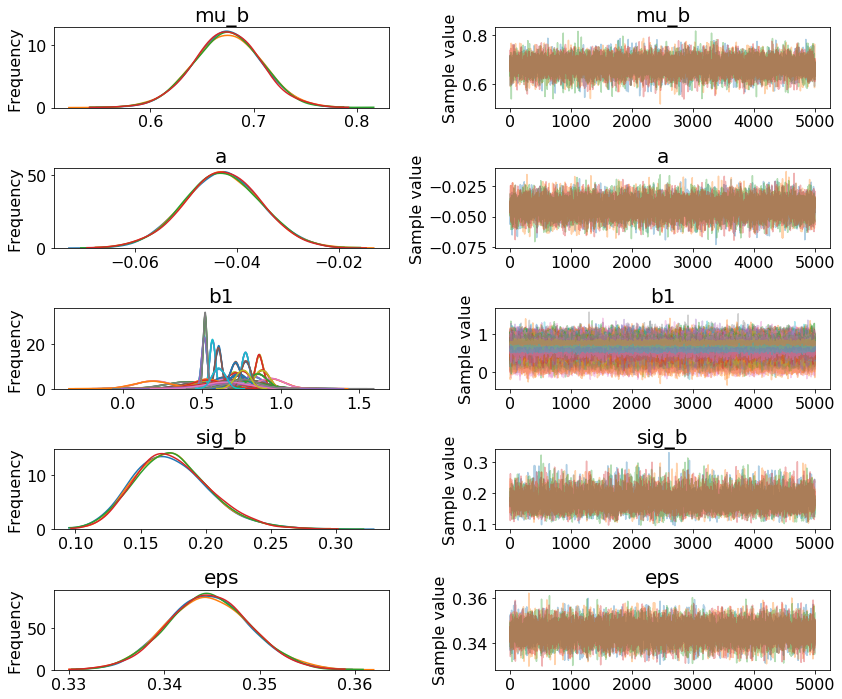

In [14]:
pm.traceplot(trace_m1);

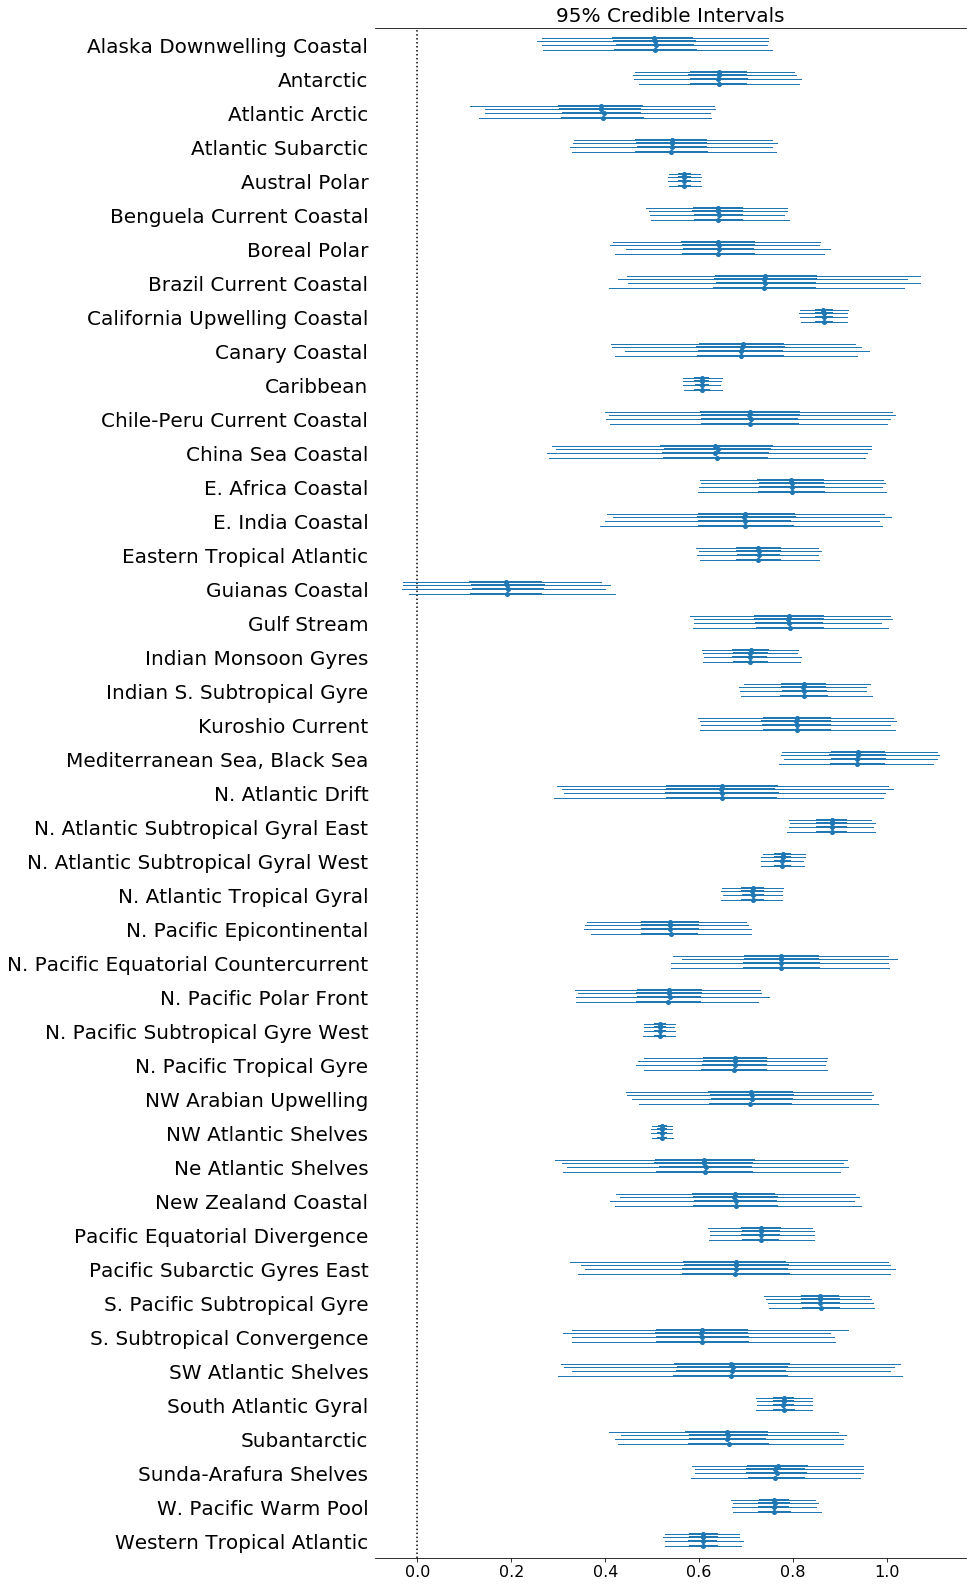

In [27]:
gs = pm.forestplot(trace_m1, varnames=['b1'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)],
                   plot_kwargs=dict(fontsize=20)
                  )
f = pl.gcf()
f.set_figheight(25)
f.set_figwidth(20)
f.savefig('m1_b1.png', dpi=300)

In [22]:
with pm.Model() as m2:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    a = pm.Normal('a', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    mu_log_chl = a + b1[provIdx] * x_pc_s[0] \
                   + b2[provIdx] * x_pc_s[1]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m2 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b2, b1, a, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1]
 10%|▉         | 998/10000 [00:09<01:30, 99.86it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:50<00:00, 196.65it/s]


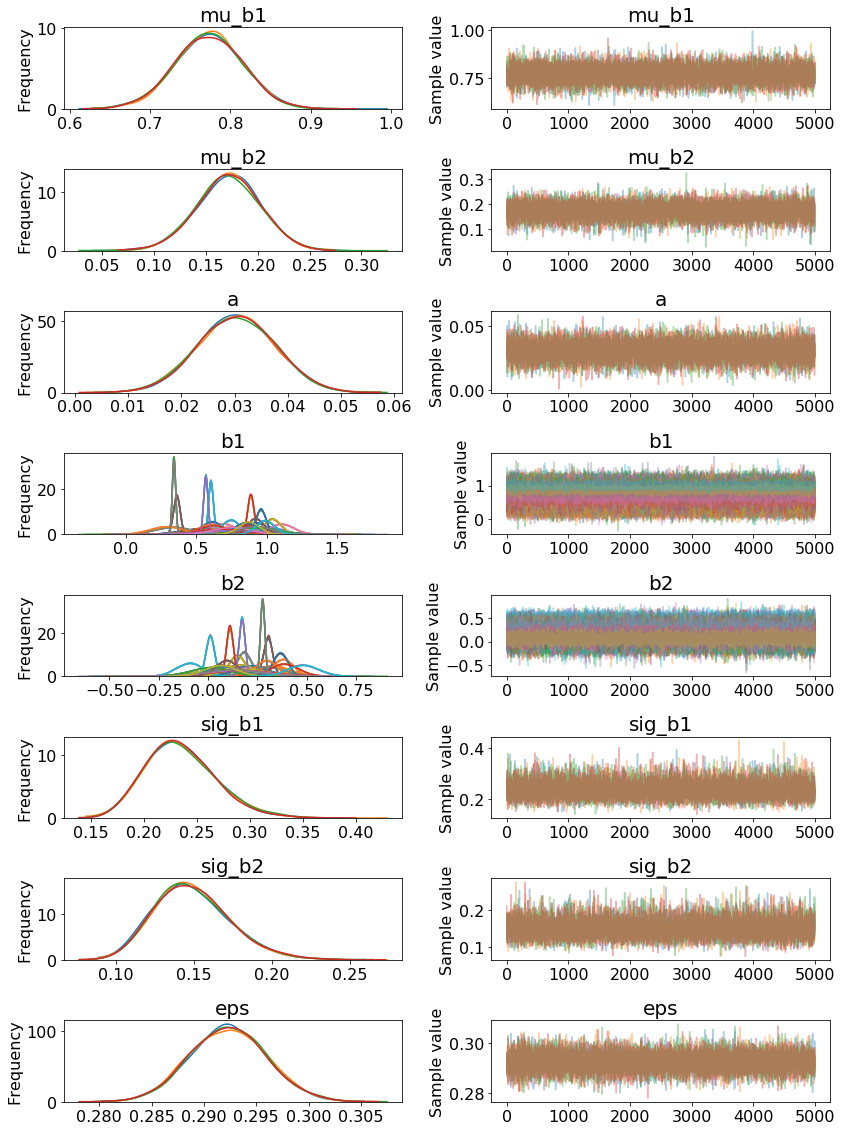

In [23]:
pm.traceplot(trace_m2);

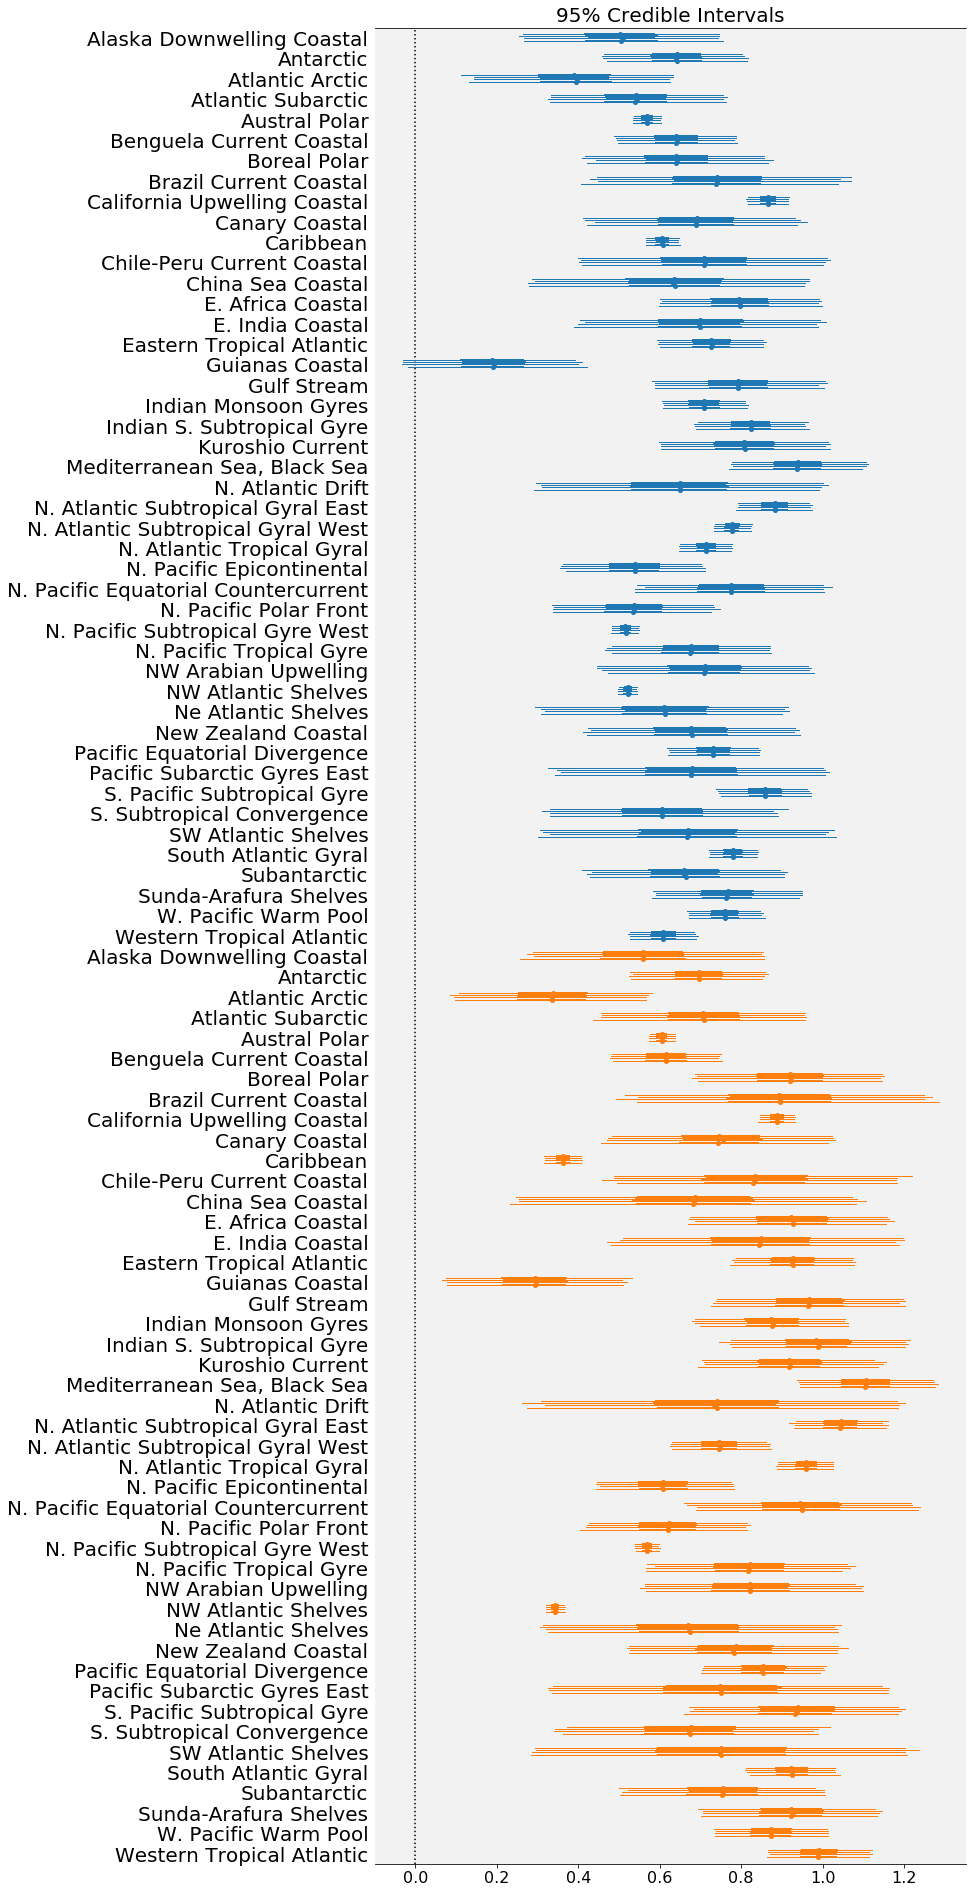

In [29]:
gs = pm.forestplot([trace_m1, trace_m2],# models=[m1, m2],
                   varnames=['b1'], rhat=False, colors='cycle',
                   ylabels=[prov_mapping[i] for i in range(n_provinces)]*2,
                   plot_kwargs=dict(fontsize=20))
f = pl.gcf()
f.set_figheight(30)
f.set_figwidth(20)
f.savefig('m1_m2_b1.png', dpi=300)

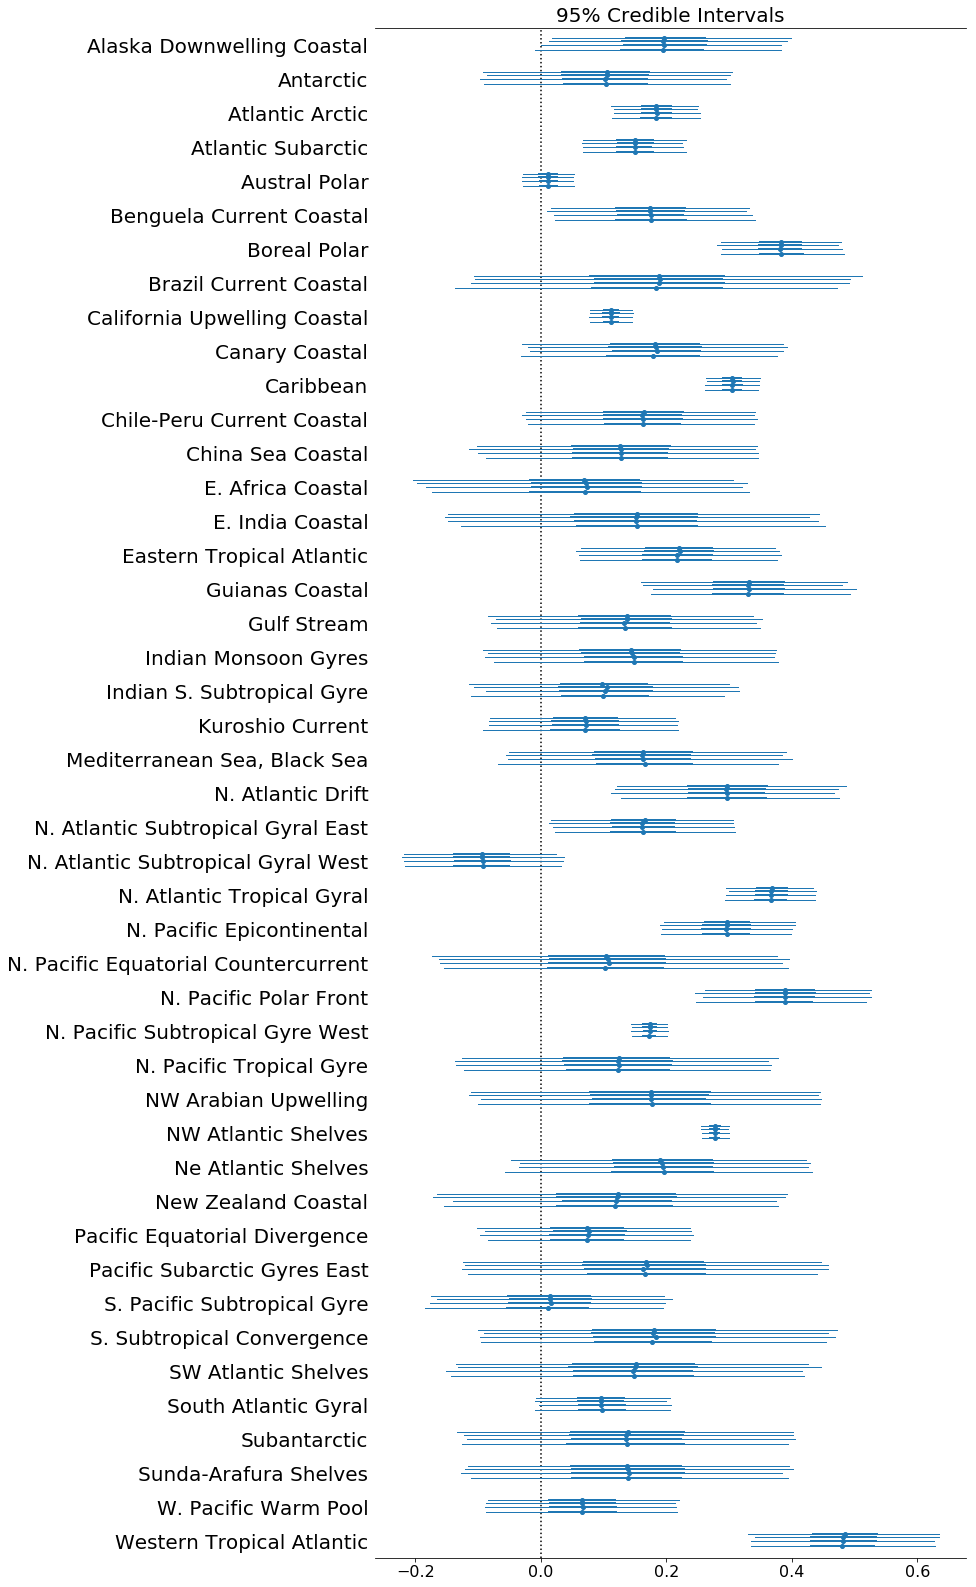

In [39]:
gs = pm.forestplot(trace_m2, varnames=['b2'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)],
                   plot_kwargs=dict(fontsize=20)
                  )
f = pl.gcf()
f.set_figheight(25)
f.set_figwidth(20)
f.savefig('m2_b2.png', dpi=300)

In [34]:
with pm.Model() as m3:
    "Varying slopes MLR on PC1 and PC2 only"
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)
    sig_b1 = pm.HalfCauchy('sig_b1', 2.5)
    mu_b2 = pm.Normal('mu_b2', mu=0, sd=100)
    sig_b2 = pm.HalfCauchy('sig_b2', 2.5)
    mu_b3 = pm.Normal('mu_b3', mu=0, sd=100)
    sig_b3 = pm.HalfCauchy('sig_b3', 2.5)
    a = pm.Normal('a', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=mu_b1, sd=sig_b1, shape=n_provinces)
    b2 = pm.Normal('b2', mu=mu_b2, sd=sig_b2, shape=n_provinces)
    b3 = pm.Normal('b3', mu=mu_b3, sd=sig_b3, shape=n_provinces)
    mu_log_chl = a + b1[provIdx] * x_pc_s[0] \
                   + b2[provIdx] * x_pc_s[1] \
                   + b3[provIdx] * x_pc_s[2]
    sigma_log_chl = pm.HalfNormal('eps', sd=5)
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl,
                        observed=log_chl_obs)
    trace_m3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b3, b2, b1, a, sig_b3_log__, mu_b3, sig_b2_log__, mu_b2, sig_b1_log__, mu_b1]
  4%|▍         | 386/10000 [00:09<04:08, 38.63it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [01:48<00:00, 92.06it/s]


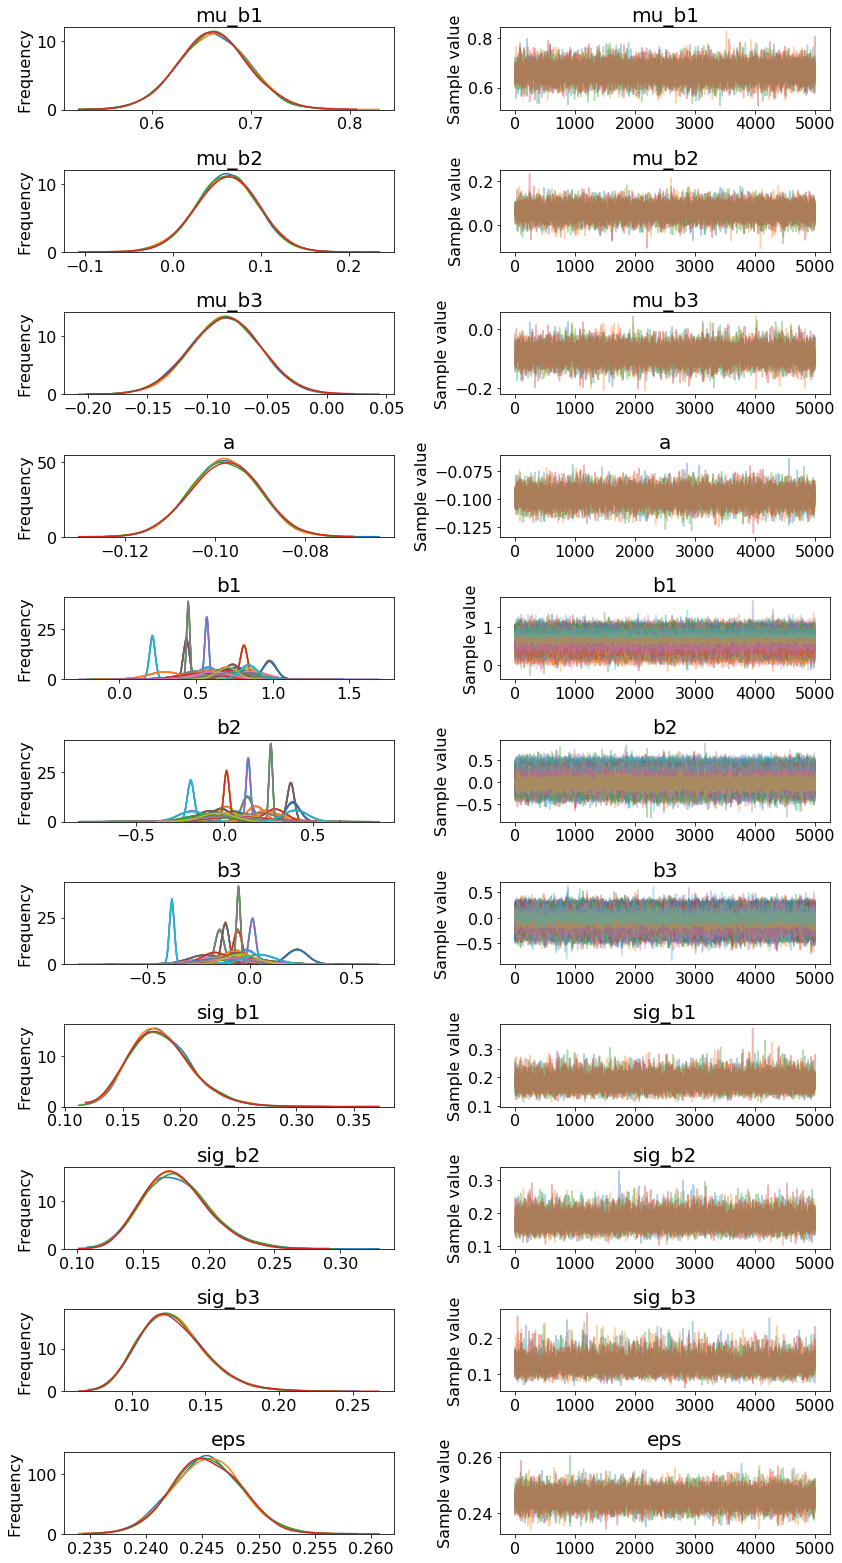

In [35]:
pm.traceplot(trace_m3);

In [45]:
type(gs)

matplotlib.gridspec.GridSpec

In [ ]:
pm.forestplot(trace_m3, varnames='b1')

In [36]:
m1.name=  'm1: {pc1}'
m2.name = 'm2: {pc1, pc2}'
m3.name = 'm3: {pc1, pc2, pc3}'
#m6.name='m_pc1...6'

In [37]:
dfcomp = pm.compare({m1: trace_m1, m2: trace_m2, m3: trace_m3})
dfcomp

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC    dWAIC weight      SE     dSE var_warn
m3: {pc1, pc2, pc3}   164.97   67.8        0      1  127.62       0        1
m2: {pc1, pc2}       1302.25  47.92  1137.29      0  111.86   87.95        1
m1: {pc1}            2361.67  19.44  2196.71      0   85.41  114.42        1

In [38]:
dfcomp_loo = pm.compare({m1: trace_m1, m2: trace_m2, m3: trace_m3}, ic='LOO')
dfcomp_loo

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO   pLOO     dLOO weight      SE     dSE shape_warn
m3: {pc1, pc2, pc3}   168.06  69.35        0   0.95  127.65       0          1
m2: {pc1, pc2}       1303.39  48.49  1135.33   0.02  111.91    87.6          1
m1: {pc1}             2362.1  19.66  2194.05   0.04   85.42  114.37          0

In [294]:
m6 = deepcopy(m0)
trace_m6 = deepcopy(trace_m0)

In [61]:
with pm.Model() as m6:
    """Hierarchical MLR with out covarying slope/intercept"""
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    
    mu_b_1 = pm.Normal('mu_b_1', 0, sd=100)
    mu_b_2 = pm.Normal('mu_b_2', 0, sd=100)
    mu_b_3 = pm.Normal('mu_b_3', 0, sd=100)
    mu_b_4 = pm.Normal('mu_b_4', 0, sd=100)
    mu_b_5 = pm.Normal('mu_b_5', 0, sd=100)
    mu_b_6 = pm.Normal('mu_b_6', 0, sd=100)
    sigma_b_1 = pm.HalfCauchy('sigma_b_1', 2.5)
    sigma_b_2 = pm.HalfCauchy('sigma_b_2', 2.5)
    sigma_b_3 = pm.HalfCauchy('sigma_b_3', 2.5)
    sigma_b_4 = pm.HalfCauchy('sigma_b_4', 2.5)
    sigma_b_5 = pm.HalfCauchy('sigma_b_5', 2.5)
    sigma_b_6 = pm.HalfCauchy('sigma_b_6', 2.5)
    
    # priors
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_provinces)
    b_offset_1 = pm.Normal('b_offset_1', mu=0, sd=1, shape=n_provinces)
    b_offset_2 = pm.Normal('b_offset_2', mu=0, sd=1, shape=n_provinces)
    b_offset_3 = pm.Normal('b_offset_3', mu=0, sd=1, shape=n_provinces)
    b_offset_4 = pm.Normal('b_offset_4', mu=0, sd=1, shape=n_provinces)
    b_offset_5 = pm.Normal('b_offset_5', mu=0, sd=1, shape=n_provinces)
    b_offset_6 = pm.Normal('b_offset_6', mu=0, sd=1, shape=n_provinces)
    a = pm.Deterministic('a', mu_a + a_offset * sigma_a)
    b1 = pm.Deterministic('b1', mu_b_1 + b_offset_1 * sigma_b_1)
    b2 = pm.Deterministic('b2', mu_b_2 + b_offset_2 * sigma_b_2)
    b3 = pm.Deterministic('b3', mu_b_3 + b_offset_3 * sigma_b_3)
    b4 = pm.Deterministic('b4', mu_b_4 + b_offset_4 * sigma_b_4)
    b5 = pm.Deterministic('b5', mu_b_5 + b_offset_5 * sigma_b_5)
    b6 = pm.Deterministic('b6', mu_b_6 + b_offset_6 * sigma_b_6)
    # a_prov = pm.Normal('a_prov', mu=mu_a, sd=sigma_a, shape=n_provinces)
    # b_prov = pm.Normal('b_prov', mu=mu_b, sd=sigma_b, shape=(n_preds, n_provinces))
    
    # forward model & model error
    mu_log_chl = a_offset[provIdx] + b1[provIdx] * x_pc_s[0]\
                                   + b2[provIdx] * x_pc_s[1]\
                                   + b3[provIdx] * x_pc_s[2]\
                                   + b4[provIdx] * x_pc_s[3]\
                                   + b5[provIdx] * x_pc_s[4]\
                                   + b6[provIdx] * x_pc_s[5]
    sigma_log_chl = pm.HalfCauchy('eps', beta=5)
    
    # likelihood
    log_chl = pm.Normal('log_chl', mu=mu_log_chl, sd=sigma_log_chl, observed=log_chl_obs)
    trace_m6 = pm.sample(2000, tune=1000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_offset_6, b_offset_5, b_offset_4, b_offset_3, b_offset_2, b_offset_1, a_offset, sigma_b_6_log__, sigma_b_5_log__, sigma_b_4_log__, sigma_b_3_log__, sigma_b_2_log__, sigma_b_1_log__, mu_b_6, mu_b_5, mu_b_4, mu_b_3, mu_b_2, mu_b_1, sigma_a_log__, mu_a]
  2%|▏         | 64/3000 [00:09<07:31,  6.50it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 3000/3000 [04:00<00:00, 12.47it/s]
The number of effective samples is smaller than 25% for some parameters.


In [154]:
df_pca_bn.Province.replace('Boreal Polar Province (Polr)', 'Boreal Polar Province',
                           inplace=True)
df_pca_bn.Province.replace('Canary Coastal Province (Eacb)',
                           'Canary Coastal Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Drift Province (Wwdr)', 
                           'N. Atlantic Drift Province', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (East) (Stge)',
                          'N. Atlantic Subtropical Gyral Province East', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Subtropical Gyral Province (West) (Stgw)',
                          'N. Atlantic Subtropical Gyral Province West', inplace=True)
df_pca_bn.Province.replace('N. Atlantic Tropical Gyral Province (Trpg)',
                          'N. Atlantic Tropical Gyral Province', inplace=True)
df_pca_bn.Province.replace('N. Pacific Subtropical Gyre Province (West)', 
                          'N. Pacific Subtropical Gyre Province West', inplace=True)
df_pca_bn.Province.replace('Pacific Subarctic Gyres Province (East)', 
                          'Pacific Subarctic Gyres Province East', inplace=True)
df_pca_bn.Province.replace('South Atlantic Gyral Province (Satg)', 
                           'South Atlantic Gyral Province', inplace=True)

In [198]:
df_pca_bn.Province = df_pca_bn.Province.str.replace(' Province', '')

In [165]:
provcode = df_pca_bn.apply(lambda x: "".join(pat.findall(x['Province'])), axis=1)
df_pca_bn.insert(df_pca_bn.columns.get_loc('Province'), 
                'ProvCode', provcode)

In [169]:
df_pca_bn.ProvCode.unique()

array(['ADCP', 'BCCP', 'CUCP', 'CCP', 'CPCCP', 'CSCP', 'EACP', 'EICP',
       'GCP', 'NASP', 'NZCP', 'NWAUP', 'NWASP', 'SASP', 'SWASP', 'AP',
       'AAP', 'ASP', 'APP', 'BPP', 'NPEP', 'CP', 'ETAP', 'IMGP', 'ISSGP',
       'NATGP', 'NPECP', 'NPTGP', 'PEDP', 'SAGP', 'WPWPP', 'WTAP', 'GSP',
       'KCP', 'MSBSP', 'NADP', 'NASGPE', 'NASGPW', 'NPPFP', 'NPSGPW',
       'PSGPE', 'SPSGP', 'SSCP', 'SP'], dtype=object)

In [200]:
prov_mapping

{0: 'Alaska Downwelling Coastal',
 1: 'Antarctic',
 2: 'Atlantic Arctic',
 3: 'Atlantic Subarctic',
 4: 'Austral Polar',
 5: 'Benguela Current Coastal',
 6: 'Boreal Polar',
 7: 'Brazil Current Coastal',
 8: 'California Upwelling Coastal',
 9: 'Canary Coastal',
 10: 'Caribbean',
 11: 'Chile-Peru Current Coastal',
 12: 'China Sea Coastal',
 13: 'E. Africa Coastal',
 14: 'E. India Coastal',
 15: 'Eastern Tropical Atlantic',
 16: 'Guianas Coastal',
 17: 'Gulf Stream',
 18: 'Indian Monsoon Gyres',
 19: 'Indian S. Subtropical Gyre',
 20: 'Kuroshio Current',
 21: 'Mediterranean Sea, Black Sea',
 22: 'N. Atlantic Drift',
 23: 'N. Atlantic Subtropical Gyral East',
 24: 'N. Atlantic Subtropical Gyral West',
 25: 'N. Atlantic Tropical Gyral',
 26: 'N. Pacific Epicontinental',
 27: 'N. Pacific Equatorial Countercurrent',
 28: 'N. Pacific Polar Front',
 29: 'N. Pacific Subtropical Gyre West',
 30: 'N. Pacific Tropical Gyre',
 31: 'NW Arabian Upwelling',
 32: 'NW Atlantic Shelves',
 33: 'Ne Atlantic

(8000, 45)

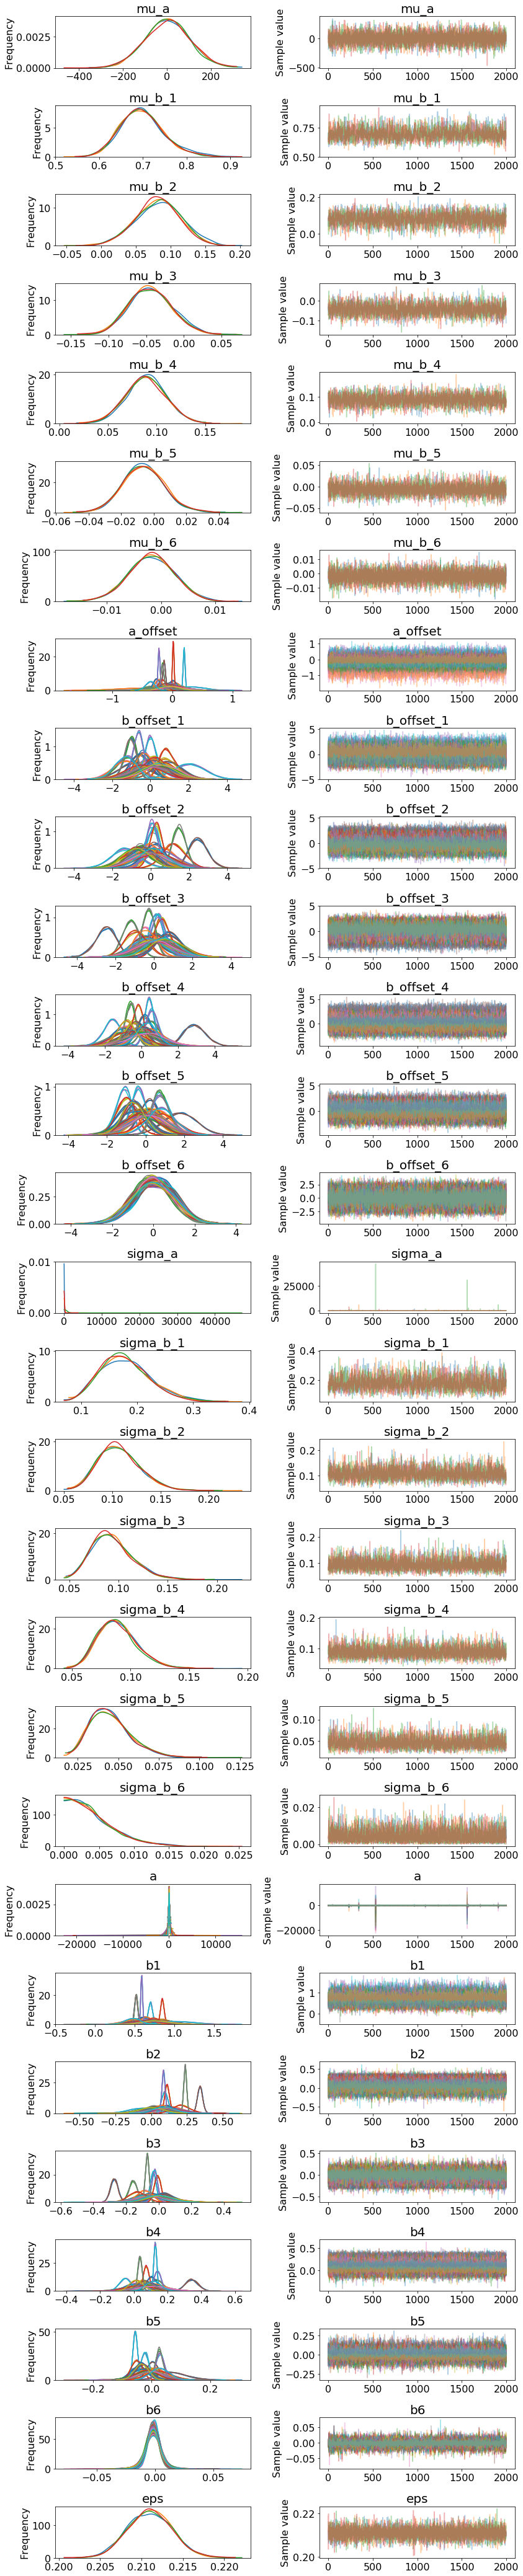

In [62]:
pm.traceplot(trace_m0);

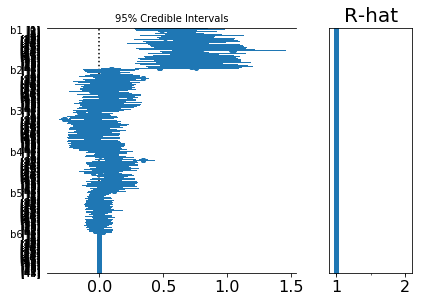

In [292]:
pm.forestplot(trace_m0, varnames=['b%d' %i for i in range(1, 7)]);

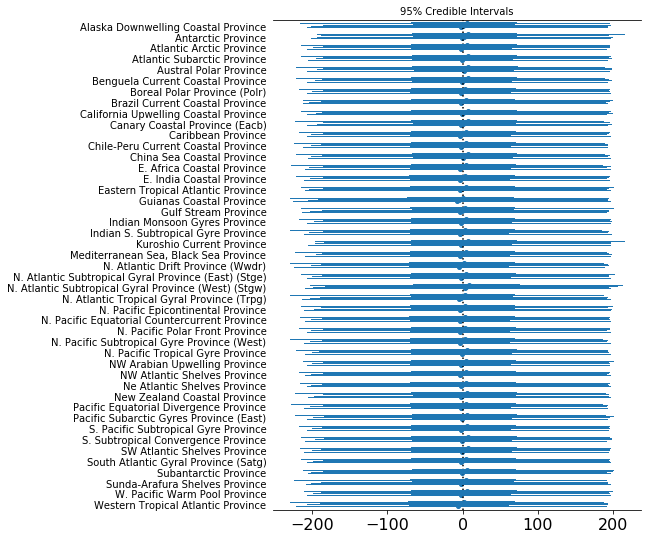

In [74]:
gs = pm.forestplot(trace_m0, varnames=['a'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

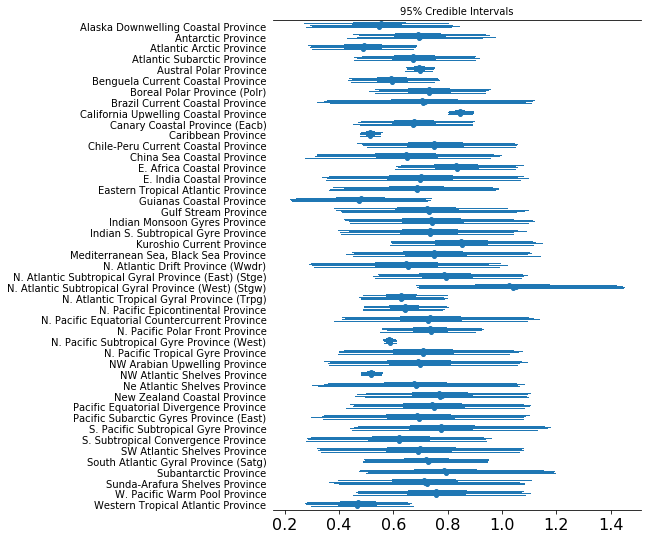

In [75]:
gs = pm.forestplot(trace_m0, varnames=['b1'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

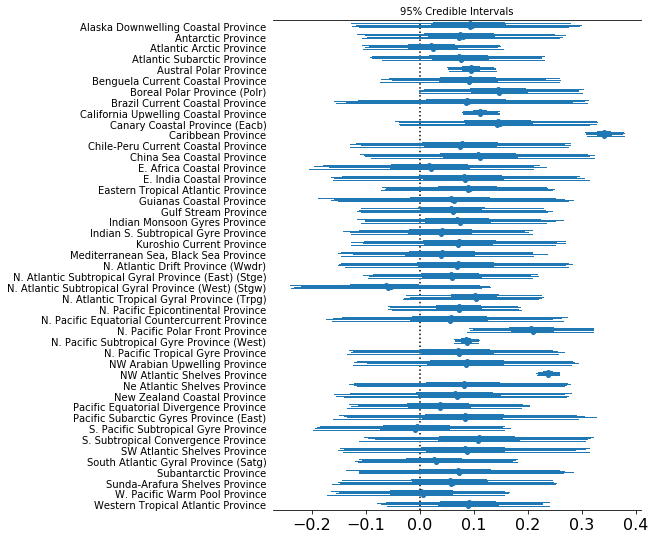

In [76]:
gs = pm.forestplot(trace_m0, varnames=['b2'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

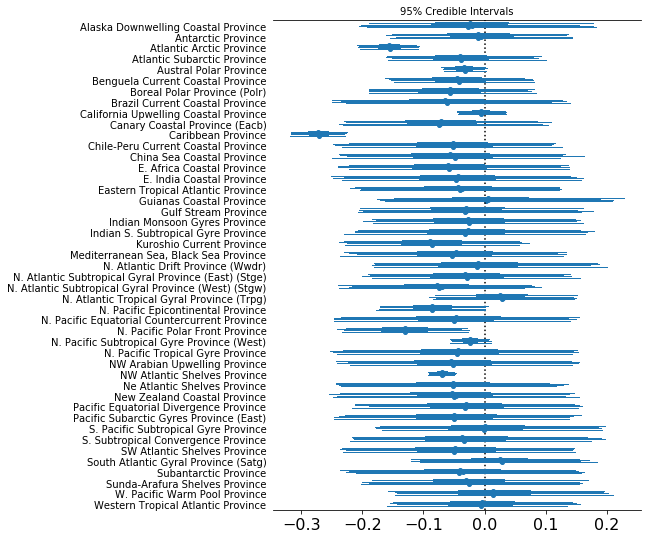

In [77]:
gs = pm.forestplot(trace_m0, varnames=['b3'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

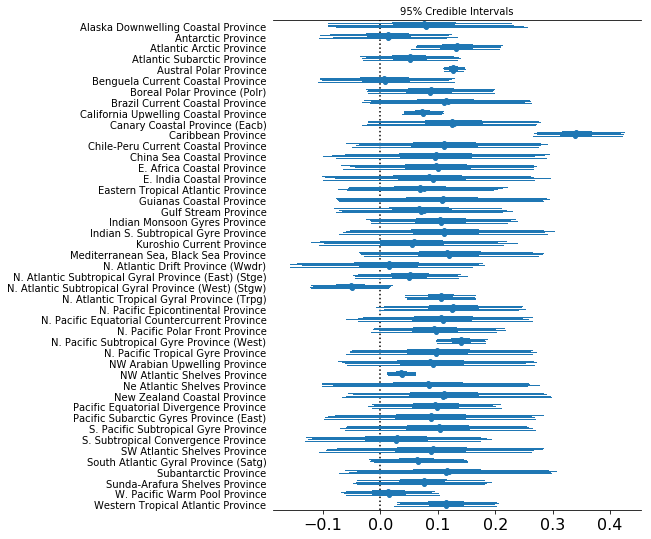

In [78]:
gs = pm.forestplot(trace_m0, varnames=['b4'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

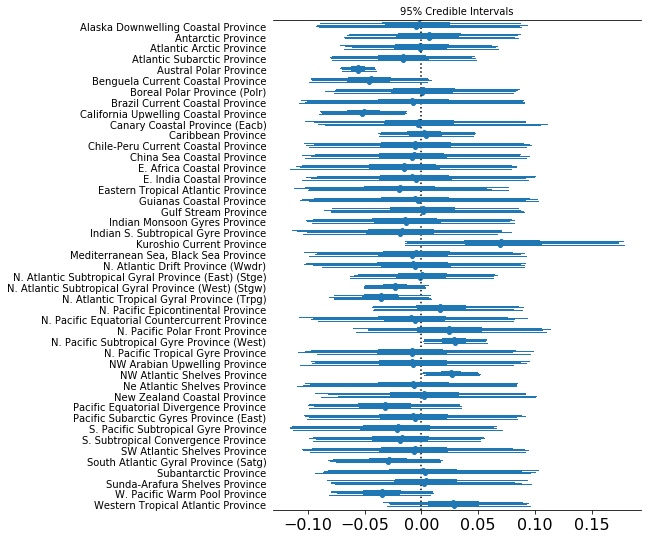

In [79]:
gs = pm.forestplot(trace_m0, varnames=['b5'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

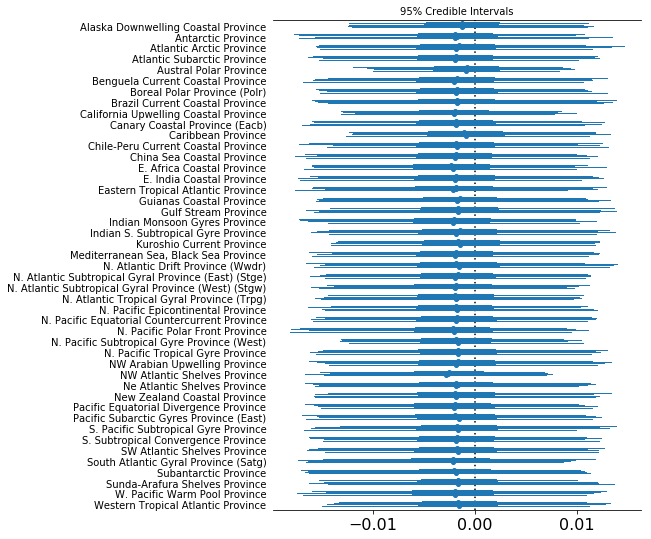

In [80]:
gs = pm.forestplot(trace_m0, varnames=['b6'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(30)

In [91]:
d_ = pd.DataFrame(columns=['chl_l', 'PC1', 'pred_chl_l_mean', 'pred_chl_l_95lo', 
                   'pred_chl_l_95hi', 'ProvIdx'])
d_['chl_l'] = df_pca_bn.chl_l.values
d_['PC1'] = df_pca_bn.PC1.values
d_['ProvIdx'] = df_pca_bn.ProvIdx

In [107]:
ppc_log_chl_m0 = pm.sample_ppc(trace_m0,
                                 samples=1000, model=m0)['log_chl']

100%|██████████| 1000/1000 [00:00<00:00, 1070.61it/s]


In [102]:
ppc_log_chl_m0.mean(axis=0)

(1000, 3311)

In [108]:
d_['pred_chl_l_mean'] = ppc_log_chl_m0.mean(axis=0)
hpd_ppc_log_chl_m0 = pm.hpd(ppc_log_chl_m0)
d_['pred_chl_l_95lo'] = hpd_ppc_log_chl_m0[:, 0]
d_['pred_chl_l_95hi'] = hpd_ppc_log_chl_m0[:, 1]
#del ppc_log_chl_m0, hpd_ppc_log_chl_m0

In [112]:
d_.head()

chl_l       PC1  pred_chl_l_mean  pred_chl_l_95lo  pred_chl_l_95hi  \
0  0.317436  0.116059         0.232137        -0.219415         0.719191   
1  0.255031  0.155281         0.418187        -0.047438         0.886311   
2  0.206286  0.122107         0.278514        -0.195651         0.730426   
3  0.198382  0.093613         0.163077        -0.265062         0.572106   
4  0.031004  0.059926         0.010117        -0.480172         0.412054   

   ProvIdx  
0        0  
1        0  
2        0  
3        0  
4        0

In [235]:
b = np.c_[trace_m0['b1'][:, i], trace_m0['b2'][:, i], trace_m0['b3'][:, i],
              trace_m0['b4'][:, i], trace_m0['b5'][:, i], trace_m0['b6'][:, i]]

In [239]:
z = df_pca_bn.loc[df_pca_bn.ProvIdx==i, ['PC%d' %j for j in range(1, 7)]].as_matrix().T

In [244]:
a_  = trace_m0['a'][:, i]

In [250]:
a_.reshape(-1,1) + b_

array([[-188.97690443, -188.98651184, -188.97324177, ..., -188.80390391,
        -188.97507047, -188.96573178],
       [ -72.60635324,  -72.61466769,  -72.60320323, ...,  -72.45701339,
         -72.60515975,  -72.5975411 ],
       [  66.14591593,   66.13742557,   66.14795741, ...,   66.30835352,
          66.14671513,   66.15422926],
       ...,
       [  44.48231002,   44.47201667,   44.48627284, ...,   44.66453403,
          44.48389369,   44.4936279 ],
       [  54.44966492,   54.44150766,   54.45195147, ...,   54.60733667,
          54.45085026,   54.45857049],
       [ -46.49298742,  -46.50137405,  -46.48887012, ...,  -46.35242531,
         -46.49122002,  -46.48307679]])

In [269]:
trace=trace_m0
b = np.c_[trace['b1'][:, i].mean(), trace['b2'][:, i].mean(),
              trace['b3'][:, i].mean(), trace['b4'][:, i].mean(),
              trace['b5'][:, i].mean(), trace['b6'][:, i].mean()]

In [276]:
b

array([[ 0.46795036,  0.08946915, -0.00352899,  0.11497998,  0.02891392,
        -0.00148323]])

In [290]:
m = compute_mdl_mean(trace_m0, i, df_pca_bn)

In [291]:
m

array([-0.07355043, -0.08322937, -0.07004171, -0.08059433, -0.07012393,
       -0.06390473, -0.07334267, -0.06917839, -0.07011225, -0.07797049,
       -0.09048307, -0.08204419, -0.08052852, -0.07304193, -0.05898603,
       -0.0715092 , -0.05924047, -0.06071456, -0.07018547, -0.08110186,
       -0.08884528, -0.0671931 , -0.08725867, -0.07889129, -0.06947228,
       -0.05961587, -0.06870533, -0.0639949 , -0.07382448, -0.07729823,
       -0.07202883, -0.06022378, -0.07814   ,  0.06754331,  0.09923125,
       -0.07207229, -0.06292937, -0.0746635 , -0.07866584, -0.07918521,
       -0.07725177,  0.01634532, -0.06848911, -0.05749344, -0.06224535,
       -0.07766504,  0.06754331,  0.09923125, -0.07207229, -0.06292937])

In [277]:
trace_m0['b1'].shape

(8000, 45)

In [288]:
def shorten_string(prov_str):
    prov_str_lst = prov_str.split(' ')
    if len(prov_str_lst) == 1:
        ttl_str = prov_str_lst[0]
    else:
        new_lst = []
        for word in prov_str_lst:
            if len(word)>4:
                word = word[:4] + '.'
            new_lst.append(word)
        ttl_str = " ".join(new_lst)
    return ttl_str


def compute_mdl_mean(trace, i, df_):
    b = np.c_[trace['b1'][:, i].mean(), trace['b2'][:, i].mean(),
              trace['b3'][:, i].mean(), trace['b4'][:, i].mean(),
              trace['b5'][:, i].mean(), trace['b6'][:, i].mean()]
    mu_ = b.dot(df_.loc[df_.ProvIdx==i,
                        ['PC%d' %j for j in range(1, 7)]
                       ].as_matrix().T)
    return mu_.flatten()

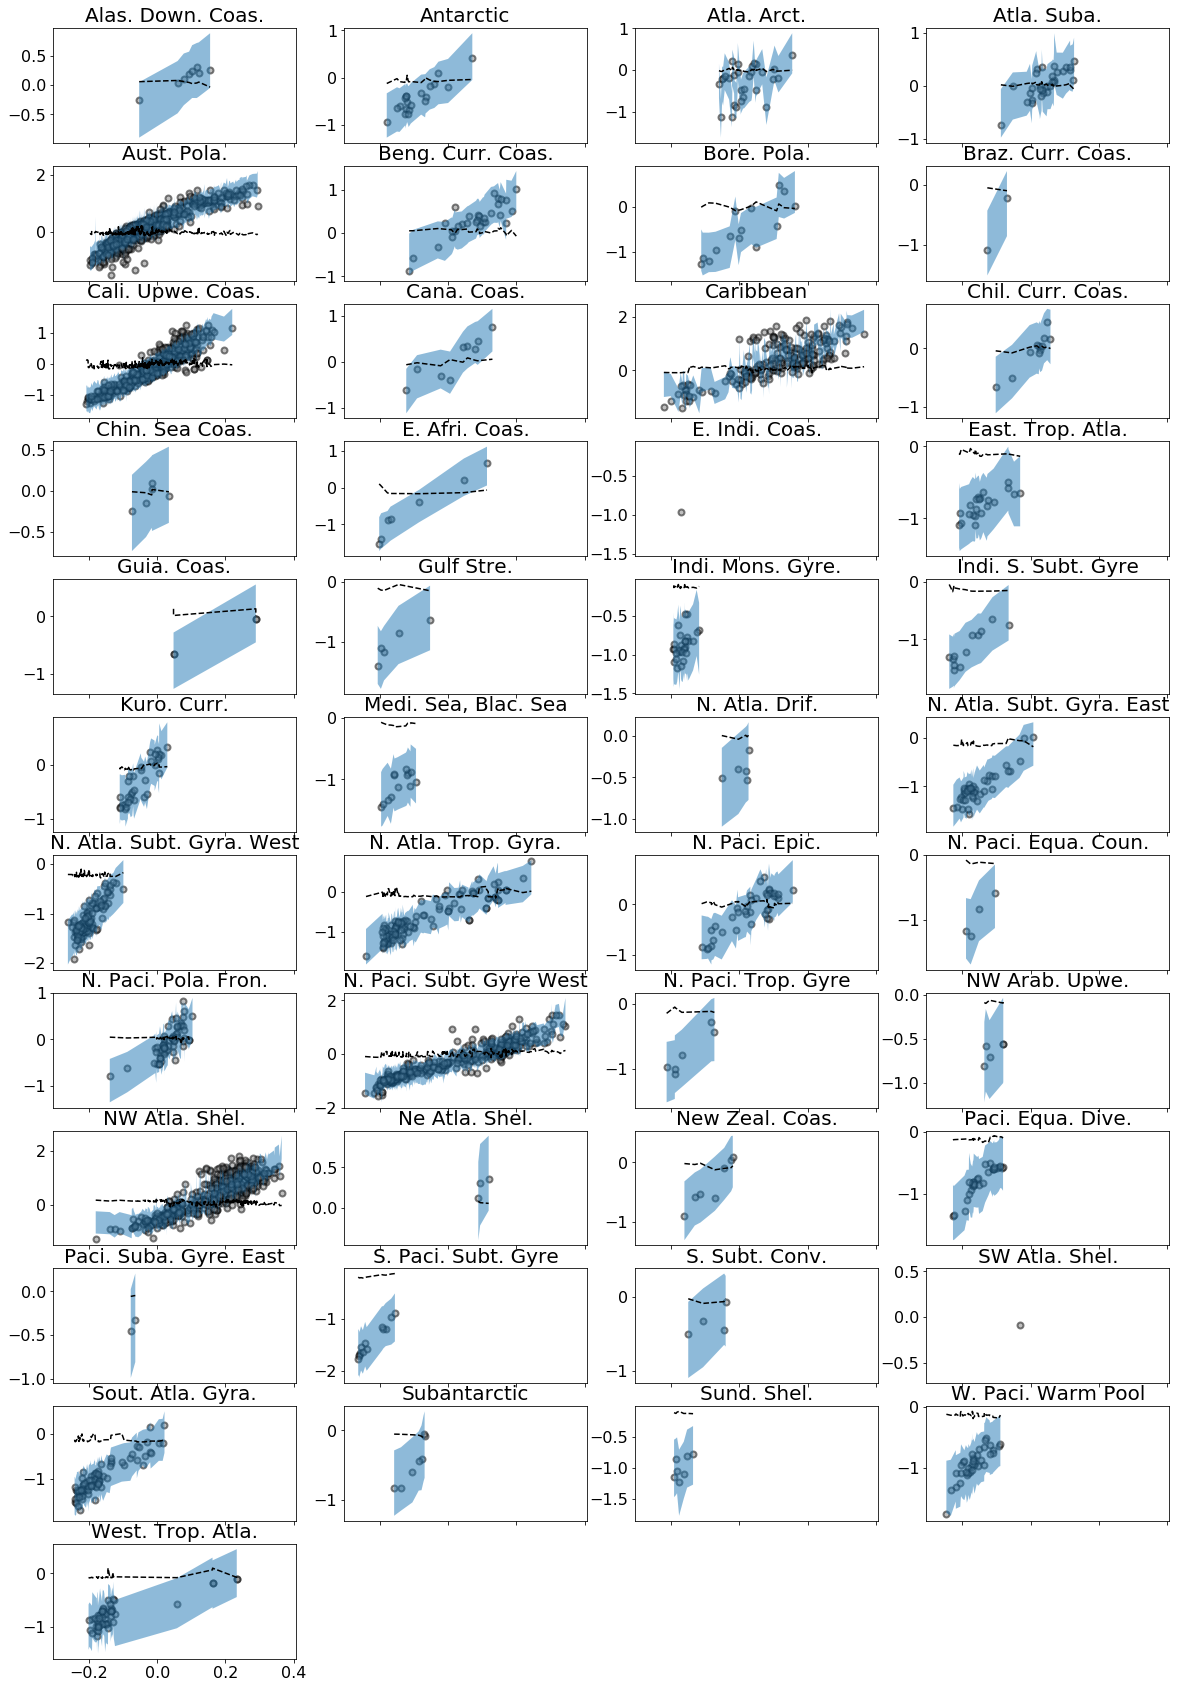

In [289]:
_, axs = pl.subplots(nrows=12, ncols=4, figsize=(20, 30), sharex=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.ProvIdx==i, ['PC1', 'pred_chl_l_mean',
                                'pred_chl_l_95lo', 
                                'pred_chl_l_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2)
    title_string = shorten_string(prov)
    ax[i].set_title(title_string)
    mu_ = compute_mdl_mean(trace_m0, i, df_pca_bn)
    ax[i].plot(xy[ix, 0], mu_, 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)
ax[45].set_visible(False)
ax[46].set_visible(False)
ax[47].set_visible(False)

In [264]:
axi=ax[i]

In [ ]:
axi.set_title()

In [ ]:
with pm.Model() as m_pca_cov:
    """Hierarchical MLR with covarying slope/intercept pairs"""